In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import missingno as msno
import plotly.graph_objects as go
from datetime import date
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# topic modeling packages 
import nltk
#nltk.download('stopwords')
import re
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel# spaCy for preprocessing
from gensim import similarities
import spacy# Plotting tools
import pyLDAvis
from matplotlib import pyplot

from pprint import pprint
import warnings
#warnings.filterwarnings("ignore")
import pickle

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report, precision_recall_curve, f1_score, auc
from xgboost import XGBClassifier
import statsmodels.api as sm

# imbelearn package
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\selectors.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\_collections.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21

## 1. Tech Dataset

In [3]:
df_tech = pd.DataFrame(pd.read_csv("Tech_cleaned.csv"))
print("Technology Shape:", df_tech.shape)

Technology Shape: (3909, 86)


### 1.1 Feature Engineering

In [4]:
# Filter to only patent IP_Type
df_tech = df_tech.loc[df_tech['IP_Type']=='Patent'].reset_index()
df_tech.shape

(2227, 87)

In [5]:
# Only keeping major divisions with sufficient number of patents; in case of multiple divisions, search through the
# list of divisions in the order of the following dict
division_mapping = {'PSD':'PSD', 
                    'BSD':'BSD', 
                    'PME':'PME', 
                    'Argonne National Laboratory':'ANL', 
                    'Marine Biological Laboratory':'MBL', 
                    'Booth':'Booth', 
                    'University of Chicago Hospital':'UCH', 
                    'SSD':'SSD', 
                    'Comprehensive Cancer Center':'CCC', 
                    'University of Chicago':'UC',
                    'Toyota Technological Institute':'TTI', 
                    'Humanities':'Humanities', 
                    'Harris':'Harris',
                    'Institute of Politics':'Politics'}

# Replce null values in Division with NA
df_tech.loc[df_tech['Division_Department'].isnull()] = 'NA'

# Add Primary Division to roll-up divisions of interest 
df_tech['Primary_Division'] = 'Others'
df_tech.loc[df_tech['Division_Department']=='NA', 'Primary_Division'] = 'NA'

for i in range(len(df_tech)):
    for key in division_mapping:
        if key in df_tech['Division_Department'][i]:
            df_tech['Primary_Division'][i] = division_mapping.get(key)
            break;

# View results 
df_tech[['Division_Department','Primary_Division']].head(15)

Division_Department Primary_Division
0           Physical Sciences Division (PSD), Physics              PSD
1           Physical Sciences Division (PSD), Physics              PSD
2           Physical Sciences Division (PSD), Physics              PSD
3           Physical Sciences Division (PSD), Physics              PSD
4           Physical Sciences Division (PSD), Physics              PSD
5           Physical Sciences Division (PSD), Physics              PSD
6      Biological Sciences Division (BSD), Pediatrics              BSD
7   Biological Sciences Division (BSD), Comprehens...              BSD
8       Biological Sciences Division (BSD), Pathology              BSD
9   Biological Sciences Division (BSD), Comprehens...              BSD
10  Biological Sciences Division (BSD), Comprehens...              BSD
11      Biological Sciences Division (BSD), Pathology              BSD
12  Biological Sciences Division (BSD), Comprehens...              BSD
13       Biological Sciences Division (BSD), Medicine              BSD
14      Biological Sciences Division (BSD), Radiology              BSD

In [6]:
# View breakout of Primary Divisions 
df_tech['Primary_Division'].value_counts()/len(df_tech)*100

BSD           64.077234
PSD           18.679838
NA             9.160305
PME            3.502470
ANL            2.065559
MBL            0.898069
Humanities     0.449035
SSD            0.269421
UCH            0.224517
Booth          0.179614
Harris         0.134710
UC             0.134710
TTI            0.089807
CCC            0.089807
Others         0.044903
Name: Primary_Division, dtype: float64

In [7]:
# Any Divisions with less than 0.5% of total records will be consolidated into 'Other' category 
other = ('Humanities', 'SSD', 'UCH', 'Booth', 'UC', 'Harris', 'TTI', 'CCC', 'Others')

df_tech.loc[df_tech['Primary_Division'].isin(other), 'Primary_Division'] = 'Other'

# Confrim changes, % breakout
df_tech['Primary_Division'].value_counts()/len(df_tech)*100

BSD      64.077234
PSD      18.679838
NA        9.160305
PME       3.502470
ANL       2.065559
Other     1.616524
MBL       0.898069
Name: Primary_Division, dtype: float64

In [8]:
# Ensure all description columns are listed as null and not blank strings (this will impact column merging)
df_tech['Brief_Technology_Description'] = df_tech.Brief_Technology_Description.replace(r'^\s*$', np.nan, regex=True)
df_tech['Assessment_Description'] = df_tech.Assessment_Description.replace(r'^\s*$', np.nan, regex=True)
df_tech['Abstract'] = df_tech.Abstract.replace(r'^\s*$', np.nan, regex=True)

# Some of the descriptions include "See ...". We want to remove these, as they do not provide any insight
df_tech['Brief_Technology_Description'] = df_tech.Brief_Technology_Description.replace(r'^SEE .*', np.nan, regex=True)
df_tech['Brief_Technology_Description'] = df_tech.Brief_Technology_Description.replace(r'^See .*', np.nan, regex=True)

df_tech['Assessment_Description'] = df_tech.Assessment_Description.replace(r'^SEE .*', np.nan, regex=True)
df_tech['Assessment_Description'] = df_tech.Assessment_Description.replace(r'^See .*', np.nan, regex=True)

df_tech['Abstract'] = df_tech.Abstract.replace(r'^SEE .*', np.nan, regex=True)
df_tech['Abstract'] = df_tech.Abstract.replace(r'^See .*', np.nan, regex=True)

# Merge Abstract, Assessment_Description, and Brief_Technology_Description together to populate null values in each
# Brief_Technology_Description has the most information, so we will use this as the base column 
df_tech.Brief_Technology_Description = df_tech.Brief_Technology_Description.fillna(df_tech.Assessment_Description)
df_tech.Brief_Technology_Description = df_tech.Brief_Technology_Description.fillna(df_tech.Abstract)
df_tech.Brief_Technology_Description = df_tech.Brief_Technology_Description.fillna(df_tech.Title)

# Remove columns that have been merged into the Brief Descriptio
del df_tech['Assessment_Description']
del df_tech['Abstract']

# Confrirm we are not seeing any common issues in Breif_Technology_Description field (NA will be removed later)
df_tech.Brief_Technology_Description.value_counts().sort_values(ascending=False).nlargest(10)

NA                                                                                                                204
B:HB                                                                                                               14
Use and/or embodiment of SlipChip.                                                                                 12
System for Monitoring an Industrial Process and Determining Sensor Status                                           2
Industrial Process Surveillance System                                                                              2
A compact bellows-driven diamond anvil cell for high-pressure, low-temperature                                      2
B:SP                                                                                                                2
Scripps is lead                                                                                                     2
A New Monofunctional Phosphonic Acid Ion Exchange Resin 

### 1.2 Filtering

In [9]:
#Filter to patents that we are the leading institution
df_tech = df_tech.loc[df_tech['We_are_not_the_lead_institution']=='No']

### 1.3 Drop Columns

In [10]:
# Identify columns to be kept for modeing (as outlined by Polsky Center)
columns_keep = ['Tech ID',
'Title',
'Lead_Inventor',
'Disclosure_Date',
'Division_Department',
'Owners',
'Ability_of_investigator_to_continue_research',
'Ability_to_advance_the_project_outside_the_lab',
'Abstract',
'Assessment_Description',
'Brief_Technology_Description',
'Compelling_nature_of_data',
'Detectability_of_infringement_and_enforceability',
'Development_and_regulatory_path_for_the_product',
'Freedom-to-operate_FTO_issues',
'Historical_cooperation_or_not_of_investigator',
'Identity_of_the_eventual_product',
'Impact_of_patent_on_adoption_of_technology',
'Industrial_startup_co-ownership_of_the_IP',
'Institution',
'Licensing_interest_by_a_specific_company',
'Market_feedback',
'Market_Size',
'Nature_of_improvement_over_existing_art',
'Patentability_questions',
'Risk_cost_sharing_w_other_institution',
'Size_of_Market',
'Stage_of_research']

df_tech_keep = df_tech[['Tech_ID',
'Title',
'Lead_Inventor',
'Disclosure_Date',
'Division_Department',
'Primary_Division',
'Owners',
'Ability_of_investigator_to_continue_research',
'Ability_to_advance_the_project_outside_the_lab',
'Brief_Technology_Description',
'Compelling_nature_of_data',
'Detectability_of_infringement_and_enforceability',
'Development_and_regulatory_path_for_the_product',
'Freedom-to-operate_FTO_issues',
'Historical_cooperation_or_not_of_investigator',
'Identity_of_the_eventual_product',
'Impact_of_patent_on_adoption_of_technology',
'Industrial_startup_co-ownership_of_the_IP',
'Institution',
'Licensing_interest_by_a_specific_company',
'Market_feedback',
'Market_Size',
'Nature_of_improvement_over_existing_art',
'Patentability_questions',
'Risk_cost_sharing_w_other_institution',
'Size_of_Market',
'Stage_of_research']]

# Rename Tech Title for merging purposes 
df_tech_keep.rename(columns = {'Title':'Tech_Title'}, inplace = True)

# Check new dataset shape
df_tech_keep.shape

(1904, 27)

In [11]:
# Check null values 
tech_missing = df_tech_keep.isnull().sum()

print(tech_missing)

Tech_ID                                                0
Tech_Title                                             0
Lead_Inventor                                          2
Disclosure_Date                                       35
Division_Department                                    0
Primary_Division                                       0
Owners                                              1125
Ability_of_investigator_to_continue_research           1
Ability_to_advance_the_project_outside_the_lab         2
Brief_Technology_Description                           0
Compelling_nature_of_data                              2
Detectability_of_infringement_and_enforceability       2
Development_and_regulatory_path_for_the_product        2
Freedom-to-operate_FTO_issues                          2
Historical_cooperation_or_not_of_investigator          2
Identity_of_the_eventual_product                       2
Impact_of_patent_on_adoption_of_technology             2
Industrial_startup_co-ownership

## 2. Patent Dataset

In [12]:
df_pat = pd.DataFrame(pd.read_csv("patentData_Cleaned.csv"))
print("Patent Shape:", df_pat.shape)

Patent Shape: (6843, 33)


In [13]:
df_pat.columns.to_list()

['Unnamed: 0',
 'Tech_ID',
 'Title',
 'Serial_Number',
 'Patent_Number',
 'Country',
 'Country_WIPO_ID',
 'File_Date',
 'Issue_Date',
 'Publication_Number',
 'Date_Actually_Filed',
 'Internal_ID',
 'Entity_Size',
 'Priority_Date',
 'Status_Date',
 'Is_Priority',
 'Last_Related_Update',
 'Status',
 'Lawfirm',
 'Attorney',
 'Legal_Reference_Number',
 'Inventors',
 'Application_Type',
 'Created_Date',
 'Docket_No',
 'Expire_Date',
 'IP_Manager',
 'Lead_Inventor',
 'Licensing_Manager',
 'Primary_Key',
 'Publication_Date',
 'Technology_Key',
 'Licensed']

### 2.1 Feature Engineering

In [14]:
# Consolidate the "File_Date" and "Date_Actually_Filed" into a new column named "Actually_File_Date"

# We take "Date_Actually_Filed" as main column and combine "File_Date" which generate a new column named "Actually_File_Date"
df_pat["Actually_File_Date"] = df_pat["Date_Actually_Filed"].combine_first(df_pat["File_Date"])
df_pat.drop(["Date_Actually_Filed", "File_Date"], 1, inplace=True)

# The original columns "File_Date" has 36 missing values and "Date_Actually_Filed" has 1470 missing values
miss_num = df_pat["Actually_File_Date"].isnull().sum()
print("Actually_File_Date is missing:", miss_num)

Actually_File_Date is missing: 35


In [15]:
# Remove the 35 null records in "Actually_File_Date"
df_pat = df_pat[~df_pat['Actually_File_Date'].isna()]

# Convert "object" data type to "datetime"
df_pat['Actually_File_Date'] = pd.to_datetime(df_pat['Actually_File_Date'].astype(str),format='%m/%d/%Y')

# Confirm null records have been removed 
df_pat["Actually_File_Date"].isnull().sum()

0

In [16]:
# Split "Inventors" names and count the Number of Inventors for each patent

# N is the number of inventors for each patent, the range of N is [1,19] and the average of N is 3. 
# For modeling purpose, we keep the first 5 inventors and split into multi-columns
n = 5  
inventor_names = [f'Inventors_{i}' for i in range(n)]
df_new = df_pat['Inventors'].map(lambda x:(str(x).split(','),len(str(x).split(',')))).apply(pd.Series)
df_inventor = df_new[0].apply(lambda x:x[:n]).apply(pd.Series)
df_inventor.columns=inventor_names
df_inventor.head(10)

Inventors_0       Inventors_1      Inventors_2 Inventors_3  \
0      Roland Winston               NaN              NaN         NaN   
1      Roland Winston               NaN              NaN         NaN   
2      Roland Winston               NaN              NaN         NaN   
3      Roland Winston               NaN              NaN         NaN   
4      Roland Winston               NaN              NaN         NaN   
5      Roland Winston               NaN              NaN         NaN   
6      Roland Winston               NaN              NaN         NaN   
7  Seongeun Julia Cho       Glyn Dawson              NaN         NaN   
8  Seongeun Julia Cho       Glyn Dawson              NaN         NaN   
9       Samuel Armato   Maryellen Giger   Heber MacMahon         NaN   

  Inventors_4  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  
7         NaN  
8         NaN  
9         NaN

In [17]:
# Create a column for counting the total number of inventors for each patent
df_cnt = pd.DataFrame(df_new[1])
df_cnt.columns=['Number_of_Inventors']
df_cnt.head(10)

Number_of_Inventors
0                    1
1                    1
2                    1
3                    1
4                    1
5                    1
6                    1
7                    2
8                    2
9                    3

In [18]:
# Combining 'Number_of_Inventors' to the patent dataset
df_pat = pd.concat([df_pat, df_cnt],axis=1).drop("Inventors", axis = 1)
df_pat.head(2)

Unnamed: 0   Tech_ID                                      Title  \
0           0  00-T-001  Light Collectors in Cylinderical Geometry   
1           1  00-T-002                   Radiant Energy Collector   

  Serial_Number Patent_Number         Country Country_WIPO_ID Issue_Date  \
0    05/581,613     3,957,031  *United States              US  5/18/1976   
1    05/492,074     4,002,499  *United States              US  1/11/1977   

  Publication_Number Internal_ID  ... Expire_Date      IP_Manager  \
0                     0002.1-001  ...   5/29/1995  Ginsburg, Eric   
1                     0002.2-001  ...   7/26/1994  Ginsburg, Eric   

    Lead_Inventor  Licensing_Manager Primary_Key Publication_Date  \
0  Roland Winston  Juggernauth, Anne      612078              NaN   
1  Roland Winston  Juggernauth, Anne      614263              NaN   

  Technology_Key Licensed Actually_File_Date Number_of_Inventors  
0         580932      Yes         1975-05-29                   1  
1         580933      Yes         1974-07-26                   1  

[2 rows x 32 columns]

### 2.2 Create 'Patent_Status' column based on Guidance from Polsky Center: 

1 = Patented: Everything with a valid issue date + Status='Allowed', 'Issued', 'Granted', 'Authorized' 

2 = Pending: Status = 'Opposition', 'In Appeal', 'In Interference', 'Pending'

3 = Abandoned: Status= 'Abandoned', 'Expired - Inactive', 'Expired Prov - Filed PCT', 'Prosecution by Other Party', 'Released to Inventors', 'Released to Government'

4 = Ignore: Status= 'Expired PCT - Nationalized', 'Expired Prov - Filed in US', 'Expired PCT - Filed in US only', 'Registered (TM)', 'Registered (Copyright)'

In [19]:
# Generate lists for the patented, pending, and abandonded statuses
patented = ('Allowed', 'Issued', 'Granted', 'Authorized')
pending = ('Opposition', 'In Appeal', 'In Interference', 'Pending')
abandoned = ('Abandoned', 'Expired - Inactive', 'Expired Prov - Filed PCT', 'Prosecution by Other Party', 'Released to Inventors', 'Released to Government')
ignore = ('Expired PCT - Nationalized', 'Expired Prov - Filed in US', 'Expired PCT - Filed in US only', 'Registered (TM)', 'Registered (Copyright)')

df_pat.loc[(df_pat['Issue_Date'].notnull()) | (df_pat['Status'].isin(patented)), 'Patent_Status'] = 'Patented'
df_pat.loc[df_pat['Status'].isin(pending), 'Patent_Status'] = 'Pending'
df_pat.loc[df_pat['Status'].isin(abandoned), 'Patent_Status'] = 'Abandoned'
df_pat.loc[df_pat['Status'].isin(ignore), 'Patent_Status'] = 'Ignore'

df_pat.Patent_Status.value_counts()

Abandoned    4803
Patented      942
Pending       804
Ignore        253
Name: Patent_Status, dtype: int64

In [20]:
#Drop 'Ignore' class
#Combine 'Patented' and 'Pending' into 'fund' class
#Rename 'Abandoned' to 'no_fund'
keep = ('Patented', 'Pending', 'Abandoned')
fund = ('Patented','Pending')

df_pat = df_pat.loc[df_pat['Patent_Status'].isin(keep)]
df_pat.loc[df_pat['Patent_Status'].isin(fund), 'Patent_Status'] = 'fund'
df_pat.loc[df_pat['Patent_Status']=='Abandoned', 'Patent_Status'] = 'no_fund'

# Check number of fund/no fund inventions 
#The majority of inventions have a status of abandonded. Approximately 1,000 inventions have been successfully patented, 800 are pending, and 200 are not being reviewed for the purposes of this analysis
df_pat.Patent_Status.value_counts()

no_fund    4803
fund       1746
Name: Patent_Status, dtype: int64

In [21]:
# Review Status of inventions that have an issue date
df_pat.loc[df_pat['Issue_Date'].notnull()]['Status'].value_counts()

Abandoned                     1009
Issued                         868
Expired - Inactive             545
Prosecution by Other Party      76
Granted                         36
Released to Inventors           29
Opposition                       2
In Appeal                        1
Name: Status, dtype: int64

In [22]:
# Here are the null values in the new 'Patent_Status' column matches the null values in the original 'Status' column, confirming we have classified all viable records
# There are 6b records don't have a 'Patent_Status'
print('Null values in Patent_Status column:', df_pat.Patent_Status.isnull().sum())
print('Null values in Status column:', df_pat.Status.isnull().sum())

Null values in Patent_Status column: 0
Null values in Status column: 0


In [23]:
# Remove the null records in "Patent_Status"
df_pat = df_pat[~df_pat['Patent_Status'].isna()]

# Confirm removal 
df_pat.Patent_Status.isnull().sum()

0

In [24]:
# Final column list of Patent data before feature selection
df_pat.columns.to_list()

['Unnamed: 0',
 'Tech_ID',
 'Title',
 'Serial_Number',
 'Patent_Number',
 'Country',
 'Country_WIPO_ID',
 'Issue_Date',
 'Publication_Number',
 'Internal_ID',
 'Entity_Size',
 'Priority_Date',
 'Status_Date',
 'Is_Priority',
 'Last_Related_Update',
 'Status',
 'Lawfirm',
 'Attorney',
 'Legal_Reference_Number',
 'Application_Type',
 'Created_Date',
 'Docket_No',
 'Expire_Date',
 'IP_Manager',
 'Lead_Inventor',
 'Licensing_Manager',
 'Primary_Key',
 'Publication_Date',
 'Technology_Key',
 'Licensed',
 'Actually_File_Date',
 'Number_of_Inventors',
 'Patent_Status']

### 2.3 Drop Columns for Patent Data

In [25]:
# Identify columns to be kept for modeling (as outlined by the Polsky Center)
columns_keep_pat = ['Tech_ID',
'Title',
'Country_WIPO_ID',
'Actually_File_Date',
'Is_Priority',
'Lawfirm',
'Attorney',
'Patent_Status',
'Number_of_Inventors',
'Application_Type'
]

df_pat_keep = df_pat[['Tech_ID',
'Title',
'Country_WIPO_ID',
'Actually_File_Date',
'Is_Priority',
'Lawfirm',
'Attorney',
'Patent_Status',
'Number_of_Inventors',
'Application_Type']]

# Rename Title column for merging purposes 
df_pat_keep.rename(columns = {'Title':'Patent_Title'}, inplace = True)

# Check missing values in columns we keep and impute any null values with "Others"
df_pat_keep.isnull().sum()

Tech_ID                   0
Patent_Title              0
Country_WIPO_ID           0
Actually_File_Date        0
Is_Priority             289
Lawfirm                 228
Attorney               1794
Patent_Status             0
Number_of_Inventors       0
Application_Type          0
dtype: int64

In [26]:
# Impute for columns with missing values 
df_pat_keep["Is_Priority"].fillna("Other", inplace = True)
df_pat_keep["Lawfirm"].fillna("Other", inplace = True)
df_pat_keep["Attorney"].fillna("Other", inplace = True)

df_pat_keep.isnull().sum()

Tech_ID                0
Patent_Title           0
Country_WIPO_ID        0
Actually_File_Date     0
Is_Priority            0
Lawfirm                0
Attorney               0
Patent_Status          0
Number_of_Inventors    0
Application_Type       0
dtype: int64

In [27]:
df_pat_keep.shape

(6549, 10)

### 3. Merge Tech and Patent datasets with columns_keep

In [28]:
# There are 5859 rows are matched with 41 columns ("Tech ID" will be dropped later)
df_modeling = df_pat_keep.join(
df_tech_keep.set_index(["Tech_ID"]),
on=["Tech_ID"],
how="inner",
lsuffix="_x",
rsuffix="_y")

df_modeling.shape

(5506, 36)

In [29]:
# Review full list of modeling columns 
df_modeling.columns.to_list()

['Tech_ID',
 'Patent_Title',
 'Country_WIPO_ID',
 'Actually_File_Date',
 'Is_Priority',
 'Lawfirm',
 'Attorney',
 'Patent_Status',
 'Number_of_Inventors',
 'Application_Type',
 'Tech_Title',
 'Lead_Inventor',
 'Disclosure_Date',
 'Division_Department',
 'Primary_Division',
 'Owners',
 'Ability_of_investigator_to_continue_research',
 'Ability_to_advance_the_project_outside_the_lab',
 'Brief_Technology_Description',
 'Compelling_nature_of_data',
 'Detectability_of_infringement_and_enforceability',
 'Development_and_regulatory_path_for_the_product',
 'Freedom-to-operate_FTO_issues',
 'Historical_cooperation_or_not_of_investigator',
 'Identity_of_the_eventual_product',
 'Impact_of_patent_on_adoption_of_technology',
 'Industrial_startup_co-ownership_of_the_IP',
 'Institution',
 'Licensing_interest_by_a_specific_company',
 'Market_feedback',
 'Market_Size',
 'Nature_of_improvement_over_existing_art',
 'Patentability_questions',
 'Risk_cost_sharing_w_other_institution',
 'Size_of_Market',
 'S

### 3.1 Duplicate Detection and consolidation to unique records only

In [30]:
print("Unique Technology titles in the Modeling Dataset:", df_modeling['Tech_Title'].nunique())

print("Unique Patent titles in the Merged Dataset:", df_modeling['Patent_Title'].nunique())

print("Shape of the Merged dataset:", df_modeling.shape)

Unique Technology titles in the Modeling Dataset: 1051
Unique Patent titles in the Merged Dataset: 1830
Shape of the Merged dataset: (5506, 36)


In [31]:
# We see there are 4,768 records in the dataset that have the same Tech_Title/Patent_Title combination
duplicates = df_modeling[df_modeling.duplicated(subset=['Tech_Title','Patent_Title'], keep=False)]
duplicates.shape

(4463, 36)

In [32]:
#A majority of the duplication is coming from the Patents data (as expected). 
#We have a large number of unique filing dates, countries, and application types
duplicates.head()

Tech_ID                                       Patent_Title  \
5   00-T-006  Energy Transmission with Respect to Convex Sou...   
6   00-T-006  Energy Transmission with Respect to Convex Sou...   
15  00-T-010  Automated Method and System for the Segmentati...   
17  00-T-010  Automated Method and System for the Segmentati...   
18  00-T-010  Automated Method and System for the Segmentati...   

   Country_WIPO_ID Actually_File_Date Is_Priority  \
5               US         1979-08-24         Yes   
6               US         1981-07-10          No   
15              US         2000-01-18         Yes   
17              US         2001-01-18          No   
18              DE         2003-06-16          No   

                                        Lawfirm           Attorney  \
5                    Marshall, Gerstein & Borun              Other   
6                    Marshall, Gerstein & Borun              Other   
15  Oblon, Spivak, McClelland, Maier & Neustadt  Kuesters, Eckhard   
17  Oblon, Spivak, McClelland, Maier & Neustadt  Kuesters, Eckhard   
18  Oblon, Spivak, McClelland, Maier & Neustadt              Other   

   Patent_Status  Number_of_Inventors Application_Type  ...  \
5        no_fund                    1       US Utility  ...   
6        no_fund                    1     Continuation  ...   
15       no_fund                    3      Provisional  ...   
17       no_fund                    3              PCT  ...   
18       no_fund                    3    Validated EPO  ...   

   Industrial_startup_co-ownership_of_the_IP Institution  \
5                                         No        UCHI   
6                                         No        UCHI   
15                                        No        UCHI   
17                                        No        UCHI   
18                                        No        UCHI   

   Licensing_interest_by_a_specific_company Market_feedback Market_Size  \
5                                        No              No               
6                                        No              No               
15                                       No              No               
17                                       No              No               
18                                       No              No               

   Nature_of_improvement_over_existing_art Patentability_questions  \
5                                       No                      No   
6                                       No                      No   
15                                      No                      No   
17                                      No                      No   
18                                      No                      No   

   Risk_cost_sharing_w_other_institution Size_of_Market Stage_of_research  
5                                     No             No                No  
6                                     No             No                No  
15                                    No             No                No  
17                                    No             No                No  
18                                    No             No                No  

[5 rows x 36 columns]

In [33]:
# This is the list of the 10 technologies with the most assocaited rows in the dataset
df_modeling.Tech_Title.value_counts().sort_values(ascending=False).nlargest(10)

Mini-Sgcg demonstrates feasibility for exon skipping to correct limb girdle muscular dystrophy                                                     136
Protein A as a Subunit Vaccine Against Staphylococcal Disease                                                                                      123
Substituted 06-Benzylguanines and 6(4)-Benzyloxypyrimidines                                                                                         82
Microfluidic Networks for Rapid Mixing and Non-Dispersing Time-Controlled Transport and Reactions of Multiple Chemical and Biochemical Reagents     67
Identifying Centromere Sequences from Plants                                                                                                        67
Use of FTY720 in autoimmune neuropathies and other neuromuscular disorders                                                                          53
Bioelectrolytic formation of methane from CO2, water and electric power.                      

In [34]:
# Review of column with missing data
df_modeling.isnull().sum()

Tech_ID                                                0
Patent_Title                                           0
Country_WIPO_ID                                        0
Actually_File_Date                                     0
Is_Priority                                            0
Lawfirm                                                0
Attorney                                               0
Patent_Status                                          0
Number_of_Inventors                                    0
Application_Type                                       0
Tech_Title                                             0
Lead_Inventor                                          0
Disclosure_Date                                       77
Division_Department                                    0
Primary_Division                                       0
Owners                                              2321
Ability_of_investigator_to_continue_research           5
Ability_to_advance_the_project_

In [35]:
# Consolidate "Application Type" to determine a unique patent

# Sort values by Disclosure Date and Actually Filed Date
df_modeling = df_modeling.sort_values(by=['Disclosure_Date','Actually_File_Date'])
df_modeling.head(10)

Tech_ID                                       Patent_Title  \
6841    TEST01                  thelma and cristi test disclosure   
4892  73-T-001                          Radiant Energy Collection   
4893  73-T-001                          Radiant Energy Collection   
4894  75-T-001   Polysaccharide for Enhancement of Cardiac Output   
4899  77-T-002  Quaternary Derivatives of Noroxymorphone Which...   
4900  78-T-003  Methods and Materials for Detection of Estroph...   
4904  79-T-006  Sextupole System for the Correction of Spheric...   
4906  79-T-010                                Energy Transmission   
4907  79-T-010                                Energy Transmission   
4909  79-T-011                             Parabolic Concentrator   

     Country_WIPO_ID Actually_File_Date Is_Priority  \
6841              US         1900-01-02       Other   
4892              US         1973-12-28         Yes   
4893              US         1975-09-15          No   
4894              US         1976-08-02         Yes   
4899              US         1978-07-28         Yes   
4900              US         1978-09-22         Yes   
4904              US         1979-10-25         Yes   
4906              US         1975-11-03         Yes   
4907              US         1975-12-17          No   
4909              US         1980-01-18         Yes   

                         Lawfirm           Attorney Patent_Status  \
6841               Alston & Bird  Edwards, Jonathan          fund   
4892  Marshall, Gerstein & Borun     Borun, Michael       no_fund   
4893  Marshall, Gerstein & Borun     Borun, Michael       no_fund   
4894                       Other              Other       no_fund   
4899                       Other              Other       no_fund   
4900                       Other              Other       no_fund   
4904                       Other              Other       no_fund   
4906  Marshall, Gerstein & Borun              Other       no_fund   
4907  Marshall, Gerstein & Borun      Zeller, James       no_fund   
4909                       Other              Other       no_fund   

      Number_of_Inventors      Application_Type  ...  \
6841                    2           Provisional  ...   
4892                    1            US Utility  ...   
4893                    1  Continuation in Part  ...   
4894                    4            US Utility  ...   
4899                    4            US Utility  ...   
4900                    2            US Utility  ...   
4904                    2            US Utility  ...   
4906                    1            US Utility  ...   
4907                    1  Continuation in Part  ...   
4909                    1            US Utility  ...   

     Industrial_startup_co-ownership_of_the_IP Institution  \
6841                                        No        UCHI   
4892                                        No        UCHI   
4893                                        No        UCHI   
4894                                        No        UCHI   
4899                                        No        UCHI   
4900                                        No        UCHI   
4904                                        No        UCHI   
4906                                        No        UCHI   
4907                                        No        UCHI   
4909                                        No        UCHI   

     Licensing_interest_by_a_specific_company Market_feedback Market_Size  \
6841                                       No              No               
4892                                       No              No               
4893                                       No              No               
4894                                       No              No               
4899                                       No              No               
4900                                       No              No               
4904                                      

In [36]:
# Asjust Patent_Title column to lowercase all values and remove extra whitespace to avoid duplicates 
# lowercase 
df_modeling['Patent_Title'] = df_modeling['Patent_Title'].str.lower()
# remove extra white space 
df_modeling['Patent_Title'] = df_modeling['Patent_Title'].str.strip()

# Group by Tech_Title, Patent_Title, Disclosure_Date, and Country_WIPO_ID. 
# These columns indicate a unique record for the purposes of modeling  
df_modeling = df_modeling.groupby(['Tech_Title','Disclosure_Date','Country_WIPO_ID'])
df_modeling.head(10)

Tech_ID                                       Patent_Title  \
6841    TEST01                  thelma and cristi test disclosure   
4892  73-T-001                          radiant energy collection   
4893  73-T-001                          radiant energy collection   
4894  75-T-001   polysaccharide for enhancement of cardiac output   
4899  77-T-002  quaternary derivatives of noroxymorphone which...   
4900  78-T-003  methods and materials for detection of estroph...   
4904  79-T-006  sextupole system for the correction of spheric...   
4906  79-T-010                                energy transmission   
4907  79-T-010                                energy transmission   
4909  79-T-011                             parabolic concentrator   
4908  79-T-011  compound parabolic concentrator with cavity fo...   
4917  80-T-005                  recombinant materials and methods   
4918  80-T-005                  recombinant methods and materials   
4920  80-T-005                  recombinant methods and materials   
4921  80-T-005                  recombinant methods and materials   
4919  80-T-005                  recombinant methods and materials   
4922  81-T-003  corrector for axial aberrations in electron op...   
4936  83-T-008  multiple sextupole system for the correction o...   
4943  84-T-002                                     cubylmetallics   
4940  84-T-002                                 cubane derivatives   
4941  84-T-002                                 cubane derivatives   
4942  84-T-002                                 cubane derivatives   
4985  86-T-011  antibody to human progesterone receptor and di...   
4986  86-T-011  antibody to human progesterone receptor and di...   
4988  86-T-012             contrast agents for ultrasound imaging   
4987  86-T-012             contrast agents for ultrasonic imaging   
4990  86-T-014                mobile radiography alignment device   
4989  86-T-014                                 mobile radiography   
5013  87-T-013  portable system for choosing pre-operative pat...   
5011  87-T-013               portable medical data entry computer   
5008  87-T-013                                        health quiz   
5009  87-T-013                                        health quiz   
5010  87-T-013                                        health quiz   
5012  87-T-013  portable medical interactive test selector hav...   
5017  87-T-022             production of autocrine growth factors   
5015  87-T-022  methods and compositions for the preparation a...   
5016  87-T-022  methods and compositions for the preparation a...   
5018  87-T-022  regeneration of kidney tissue and use of autoc...   
5027  87-T-026  method and system for enhancement and detectio...   
5019  87-T-024  method and system for localization of inter-ri...   
5024  87-T-025  method and system for removing scatter and vei...   
5020  87-T-024  method and system for localization of inter-ri...   
5025  87-T-025  method and system for removing scatter and vei...   
5028  87-T-026  method and system for enhancement and detectio...   
5021  87-T-024  method and system for localization of inter-ri...   
5026  87-T-025  method and system for removing scatter and vei...   
5029  87-T-026  method and system for enhancement and detectio...   
5022  87-T-024  method and system for localization of inter-ri...   
5023  87-T-025  method and system for removing scatter and vei...   
5031  87-T-031  magnetic resonance analysis of substances in s...   
5033  87-T-032  selective isotopic labeling of spin labels for...   
5032  87-T-032                 magnetic/electronic spin resonance   
5034  87-T-035              high flux solar energy transformation   
5035  87-T-035              high flux solar energy transformation   
5036  87-T-035              high flux solar energy transformation   
5037  87-T-035              high flux solar energy transformation   
5038  87-T-035              high flux solar energy transformation   
5039 

In [37]:
# Take the first available Actually_Filed_Date from that unique entry
df_modeling = df_modeling.first().reset_index()

# Check shape of consolidated dataset 
df_modeling.shape

(3168, 36)

In [38]:
# Drop one test row "TEST01" and then drop the "Tech_ID" column
df_modeling = df_modeling[df_modeling["Tech_ID"].str.contains("TEST01") == False]
  
df_modeling.shape

(3167, 36)

In [39]:
# check the types of Application_Type values to determine if it looks like we are keeping to correct applications
df_modeling['Application_Type'].value_counts()

Nationalized PCT        1213
Validated EPO            838
Provisional              718
US Utility               273
Foreign, Non-PCT          74
Continuation in Part      15
Divisional                14
PCT                       12
Continuation               7
Trademark                  3
Name: Application_Type, dtype: int64

### 4. Feature Engineering 

### 4.1 LDA Topic Modeling

In [40]:
# Prepare stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Convert Tech_Titles to list and tokenize
data = df_modeling.Tech_Title.values.tolist()

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['grid', 'cassette', 'for', 'portable', 'radiography']]


In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['grid', 'cassette', 'for', 'portable', 'radiography']


In [42]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [43]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['grid', 'cassette', 'portable', 'radiography']]


In [44]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [45]:
# Develop LDA Topic Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the keyword of topics
pprint(lda_model.print_topics())
# This applies the lda model to our corpus of titles, which we can use to assign a majority topic for each Tech_Topic 
doc_lda = lda_model[corpus]

[(0,
  '0.059*"treatment" + 0.043*"cell" + 0.035*"cancer" + 0.024*"opioid" + '
  '0.021*"growth" + 0.021*"tumor" + 0.021*"antagonist" + 0.019*"anti" + '
  '0.016*"attenuate" + 0.016*"agent"'),
 (1,
  '0.044*"method" + 0.039*"protein" + 0.037*"disease" + 0.031*"human" + '
  '0.028*"virus" + 0.025*"system" + 0.022*"receptor" + 0.018*"staphylococcal" '
  '+ 0.017*"gene" + 0.016*"mouse"'),
 (2,
  '0.119*"use" + 0.031*"herpe" + 0.028*"new" + 0.026*"optical" + '
  '0.025*"vaccine" + 0.022*"neuromuscular_disorder" + 0.014*"synthetic" + '
  '0.014*"type" + 0.014*"radio_sensitizer" + 0.011*"therapeutic"')]


In [46]:
# Compute Model Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.


Perplexity:  -7.194942540930541


In [47]:
# Visualize the topics
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.121573  0.261808       1        1  39.828985
0      0.166646 -0.231741       2        1  30.413735
2     -0.288219 -0.030067       3        1  29.757280, topic_info=                           Term        Freq       Total Category  logprob  \
93                          use  648.000000  648.000000  Default  30.0000   
20                    treatment  329.000000  329.000000  Default  29.0000   
155                      method  318.000000  318.000000  Default  28.0000   
32                         cell  237.000000  237.000000  Default  27.0000   
115                     protein  282.000000  282.000000  Default  26.0000   
203                     disease  267.000000  267.000000  Default  25.0000   
17                       cancer  199.000000  199.000000  Default  24.0000   
134                       herpe  171.000000  171.000000  Default  23.0000   
36                        human  223.000000  223.000000  Default  22.0000   
571                       virus  207.000000  207.000000  Default  21.0000   
220                         new  154.000000  154.000000  Default  20.0000   
345                     optical  143.000000  143.000000  Default  19.0000   
207                      system  179.000000  179.000000  Default  18.0000   
567                     vaccine  136.000000  136.000000  Default  17.0000   
1610                     opioid  133.000000  133.000000  Default  16.0000   
98                     receptor  160.000000  160.000000  Default  15.0000   
2271     neuromuscular_disorder  121.000000  121.000000  Default  14.0000   
598                      growth  119.000000  119.000000  Default  13.0000   
87                        tumor  118.000000  118.000000  Default  12.0000   
110                  antagonist  118.000000  118.000000  Default  11.0000   
252                        anti  106.000000  106.000000  Default  10.0000   
595              staphylococcal  129.000000  129.000000  Default   9.0000   
80                         gene  124.000000  124.000000  Default   8.0000   
399                       mouse  118.000000  118.000000  Default   7.0000   
251                       agent   86.000000   86.000000  Default   6.0000   
325                       treat  113.000000  113.000000  Default   5.0000   
594                   attenuate   88.000000   88.000000  Default   4.0000   
507                      factor   83.000000   83.000000  Default   3.0000   
386                   synthetic   79.000000   79.000000  Default   2.0000   
1929                    subunit  104.000000  104.000000  Default   1.0000   
155                      method  318.009291  318.696747   Topic1  -3.1317   
115                     protein  281.541777  282.159387   Topic1  -3.2535   
203                     disease  266.611662  267.242542   Topic1  -3.3080   
36                        human  222.658378  223.267650   Topic1  -3.4882   
207                      system  178.550272  179.157238   Topic1  -3.7089   
98                     receptor  160.247974  160.867265   Topic1  -3.8171   
571                       virus  206.354598  207.241324   Topic1  -3.5642   
595              staphylococcal  128.415027  129.065059   Topic1  -4.0385   
80                         gene  124.290448  124.921804   Topic1  -4.0712   
325                       treat  112.928349  113.778510   Topic1  -4.1671   
1929                    subunit  103.143938  104.075251   Topic1  -4.2577   
133                    function   63.738710   64.326706   Topic1  -4.7390   
99                     specific   72.107123   72.788418   Topic1  -4.6157   
167                   detection   61.940950   62.545178   Topic1  -4.7676   
399                       mouse  117.434961  118.581327   Topic1  -4.1279   
402                   inhibitor   92.157453   93.131732   Topic1  -4.3703   
1108               surveillance   64.729168   65.417002   Topic1  -4

In [195]:
# get list of tuples containing topic percentages from each Tech_Title from doc_lda
topics = pd.DataFrame(doc_lda)

# Extract the 2nd element (the percentages for each given topic) from each column containing list element
topics['topic1'] = list(zip(*topics[0]))[0]
topics['topic2'] = list(zip(*topics[0]))[1]
topics['topic3'] = list(zip(*topics[0]))[2]
#topics['topic4'] = list(zip(*topics[0]))[3]

topics['topic1'] = list(zip(*topics['topic1']))[1]
topics['topic2'] = list(zip(*topics['topic2']))[1]
topics['topic3'] = list(zip(*topics['topic3']))[1]
#topics['topic4'] = list(zip(*topics['topic4']))[1]

# convert series objects to float for comparison 
topics['topic1'] = topics['topic1'].astype(str).astype(float)
topics['topic2'] = topics['topic2'].astype(str).astype(float)
topics['topic3'] = topics['topic3'].astype(str).astype(float)
#topics['topic4'] = topics['topic4'].astype(str).astype(float)

# create 'lda_topic' column with topic that carries majority weight for Tech_Title
topics.loc[(topics['topic1']>topics['topic2']) & (topics['topic1']>topics['topic3']), 'lda_topic'] = 1
topics.loc[(topics['topic2']>topics['topic1']) & (topics['topic2']>topics['topic3']), 'lda_topic'] = 2
topics.loc[(topics['topic3']>topics['topic1']) & (topics['topic3']>topics['topic2']), 'lda_topic'] = 3
#topics.loc[(topics['topic4']>topics['topic1']) & (topics['topic4']>topics['topic2']) & (topics['topic4']>topics['topic3']), 'lda_topic'] = 4

topics.drop(columns=[0,1,2],inplace = True)

# Check results 
topics.head(7)

topic1    topic2    topic3  lda_topic
0  0.053398  0.870574  0.076029        2.0
1  0.030686  0.718583  0.250730        2.0
2  0.045262  0.429713  0.525025        3.0
3  0.856110  0.073900  0.069990        1.0
4  0.856110  0.073900  0.069990        1.0
5  0.856110  0.073900  0.069990        1.0
6  0.856110  0.073900  0.069990        1.0

In [196]:
# Topics are relatively evenly distributed across the 4 categories
topics['lda_topic'].value_counts()/len(topics)*100

2.0    39.280076
3.0    33.154405
1.0    27.565519
Name: lda_topic, dtype: float64

In [197]:
#bind with main dataset
df_modeling = pd.concat([df_modeling, topics], axis=1)
df_modeling.head(7)

Tech_Title      Disclosure_Date  \
0           "Grid Cassette for Portable Radiography"  1991-08-08 00:00:00   
1  "Index of Depth of Anesthesia - Brain Anesthet...  2001-03-16 00:00:00   
2  "TrueQ" Microspheres for Quantitative Flow Cyt...  2011-06-01 10:00:00   
3  -3156G>A Genotyping for Optimization of Cancer...  2003-06-06 10:00:00   
4  -3156G>A Genotyping for Optimization of Cancer...  2003-06-06 10:00:00   
5  -3156G>A Genotyping for Optimization of Cancer...  2003-06-06 10:00:00   
6  -3156G>A Genotyping for Optimization of Cancer...  2003-06-06 10:00:00   

  Country_WIPO_ID   Tech_ID  \
0              US  91-T-032   
1              US  01-T-019   
2              US  11-T-068   
3              BE  03-T-067   
4              CA  03-T-067   
5              DE  03-T-067   
6              EP  03-T-067   

                                        Patent_Title Actually_File_Date  \
0  optical grid alignment system for portable rad...         1991-12-02   
1  assessment of concentration of inhalational co...         2001-03-16   
2  oligonucleotide-mediated quantitative multiple...         2012-06-15   
3  methods and compositions for predicting irinot...         2008-05-28   
4  methods and compositions for predicting irinot...         2005-11-29   
5  methods and compositions for predicting irinot...         2008-05-28   
6  methods and compositions for predicting irinot...         2005-12-01   

  Is_Priority                       Lawfirm        Attorney Patent_Status  \
0         Yes  Norton Rose Fulbright US LLP           Other       no_fund   
1         Yes       Cesari and McKenna, LLP  Tsao, Y. Rocky       no_fund   
2         Yes  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   
3          No  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   
4          No  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   
5          No  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   
6          No  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   

   ...                                        Market_Size  \
0  ...                                                      
1  ...                                                      
2  ...  The flow cytometry market is composed of instr...   
3  ...                                                      
4  ...                                                      
5  ...                                                      
6  ...                                                      

  Nature_of_improvement_over_existing_art Patentability_questions  \
0                                      No                      No   
1                                      No                      No   
2                                      No                      No   
3                                      No                      No   
4                                      No                      No   
5                                      No                      No   
6                                      No                      No   

  Risk_cost_sharing_w_other_institution Size_of_Market Stage_of_research  \
0                                    No             No                No   
1                                    No             No                No   
2                                    No             No                No   
3                                    No             No                No   
4                                    No             No                No   
5                                    No             No                No   
6                                    No             No                No   

     topic1    topic2    topic3 lda_topic  
0  0.053398  0.870574  0.076029       2.0  
1  0.030686  0.718583  0.250730       2.0  
2  0.045262  0.429713  0.525025       3.0  
3  0.856110  0.073900  0.069990       1.0  
4  0.856110  0.073900  0.069990       1.0  
5  0.856110  0.073900  0.069990       1.0  

### 4.2 Additional Feature Engineering

In [198]:
df_modeling['Primary_Division'].value_counts()

BSD      2405
PSD       563
ANL        89
PME        88
MBL        14
Other       8
Name: Primary_Division, dtype: int64

In [199]:
#Since MBL does not have many patent applications, combine it into 'Other'
df_modeling.loc[df_modeling['Primary_Division']=='MBL','Primary_Division'] = 'Other'

# Review breakout of Primary Divisions 
df_modeling['Primary_Division'].value_counts()

BSD      2405
PSD       563
ANL        89
PME        88
Other      22
Name: Primary_Division, dtype: int64

In [200]:
#Create patent counts by primary division
num_patents_division = df_modeling['Primary_Division'].value_counts().reindex(
    df_modeling.Primary_Division.unique(), fill_value=0)
num_success_patents_division = df_modeling.loc[df_modeling['Patent_Status']=='fund']['Primary_Division'].value_counts().reindex(
    df_modeling.Primary_Division.unique(), fill_value=0)
patent_by_division = pd.DataFrame({'Primary_Division':num_patents_division.index, 'Patents_in_Division':num_patents_division.values, 'Successful Patents_in_Division':num_success_patents_division.values})

patent_by_division

Primary_Division  Patents_in_Division  Successful Patents_in_Division
0              BSD                 2405                             581
1              PSD                  563                             164
2              PME                   88                              56
3            Other                   22                               7
4              NaN                    0                               0
5              ANL                   89                               0

In [201]:
#Create patent success rate by primary division and drop NaN row
patent_by_division['Division_Patent_Success_Rate'] = patent_by_division['Successful Patents_in_Division']/patent_by_division['Patents_in_Division']
patent_by_division = patent_by_division.drop([4])
patent_by_division

Primary_Division  Patents_in_Division  Successful Patents_in_Division  \
0              BSD                 2405                             581   
1              PSD                  563                             164   
2              PME                   88                              56   
3            Other                   22                               7   
5              ANL                   89                               0   

   Division_Patent_Success_Rate  
0                      0.241580  
1                      0.291297  
2                      0.636364  
3                      0.318182  
5                      0.000000

In [202]:
df_modeling = df_modeling.merge(patent_by_division)

In [203]:
# Merge patent_by_division into dataset 
df_modeling = df_modeling.merge(patent_by_division)

#Create patent counts by tech family
num_patents_tech = df_modeling['Tech_Title'].value_counts()
patent_by_tech = pd.DataFrame({'Tech_Title':num_patents_tech.index, 'Patents_in_Tech':num_patents_tech.values})
patent_by_tech

Tech_Title  Patents_in_Tech
0     Mini-Sgcg demonstrates feasibility for exon sk...               90
1     Protein A as a Subunit Vaccine Against Staphyl...               50
2     Use of FTY720 in autoimmune neuropathies and o...               42
3     Modified alpha-galactosyl ceramide for stainin...               37
4     Multicomponet Intestinal Preparation Solution ...               33
5     Staphylococcal Protein A Contributes to Persis...               31
6     Biological process for converting carbon dioxi...               28
7     Hybrid Coa and vWbp subunit vaccine derived fr...               24
8     Modulators of Nuclear Receptor Liver X Recepto...               24
9     Treatment of Cancer by Manipulation of Commens...               23
10    Bioelectrolytic formation of methane from CO2,...               22
11                          Use of New Radio Sensitizer               22
12                              Herpes Simplex Protease               22
13    Induction of Genes by Ionizing Radiation as a ...               22
14    Lubrication from Mixture of Boric Acid with Oi...               21
15    Glucocorticoid receptor-mediated cell survival...               21
16    Substituted 06-Benzylguanines and 6(4)-Benzylo...               21
17    IL-11 for the treatment of recurrent and/or ch...               20
18    Cytoprotective and Anti-inflammatory Effects D...               20
19    Isoglobotrihexosylceramide (iGb3),  the Natura...               20
20    Application of Genetically Engineered Viruses ...               19
21                  Herpes Simplex Viruses  as a Vector               19
22    Efficient Implementation of Spatially Resolved...               19
23    Membrane Permeant Inhibitor of Myosin Light Ch...               19
24             Synthetic Herpes Simplex Virus Promoters               19
25    Identification of plant metabolites that induc...               19
26                            Adaptive Optical Tweezers               18
27                              Anti-Androgen Compounds               18
28    Method for Modulation of the Functions of the ...               18
29    Recombinant Herpes Simplex Viruses, Vaccines a...               18
30    Optical Peristaltic Pumping with Holographic O...               17
31    The function of y134.5 Gene of Herps Simplex V...               16
32                                 Herpes Simplex Virus               15
33                                            Slip Chip               15
34    A novel approach to eradicate established tumo...               14
35    Use of peripheral opiate antagonists to attenu...               14
36    Design of ultrasensitive DNA-based fluorescent...               14
37                     Herpes Simplex Virus as a Vector               14
38    Rapidly Maturing Variants of the Discosoma Red...               14
39    Bioavailability of oral methylnaltrexone incre...               14
40    FN3 Monobodies Including Diversification at No...               13
41                      Optimized Optical Fractionation               13
42    Ultrasensitive Surveillance of Sensors & Proce...               13
43         Diagnostic Radiology Coupled Chemoprevention               13
44    Programmable RNA effector systems built from h...               13
45                           Modulated Optical Vortices               13
46    Reflector Design for Illumination/w Extended S...               12
47                   Synthetic polymeric mannosylations               12
48    Monoclonal antibodies that neutralize coagulas...               12
49                                   Splitting SlipChip               12
50    Manipulation of Biological Particles with Visi...               12
51     EAP and EMP as Staphylococcal Vaccine Components               12
52    Genetically-Engineered Herpes Virus for the Tr...               11
53    Methods of quantitative assessment of DNA-bind...               11
54           Opioid antagonist

In [204]:
df_modeling = df_modeling.merge(patent_by_tech)
df_modeling.head()

Tech_Title      Disclosure_Date  \
0           "Grid Cassette for Portable Radiography"  1991-08-08 00:00:00   
1  "Index of Depth of Anesthesia - Brain Anesthet...  2001-03-16 00:00:00   
2  "TrueQ" Microspheres for Quantitative Flow Cyt...  2011-06-01 10:00:00   
3  -3156G>A Genotyping for Optimization of Cancer...  2003-06-06 10:00:00   
4  -3156G>A Genotyping for Optimization of Cancer...  2003-06-06 10:00:00   

  Country_WIPO_ID   Tech_ID  \
0              US  91-T-032   
1              US  01-T-019   
2              US  11-T-068   
3              BE  03-T-067   
4              CA  03-T-067   

                                        Patent_Title Actually_File_Date  \
0  optical grid alignment system for portable rad...         1991-12-02   
1  assessment of concentration of inhalational co...         2001-03-16   
2  oligonucleotide-mediated quantitative multiple...         2012-06-15   
3  methods and compositions for predicting irinot...         2008-05-28   
4  methods and compositions for predicting irinot...         2005-11-29   

  Is_Priority                       Lawfirm        Attorney Patent_Status  \
0         Yes  Norton Rose Fulbright US LLP           Other       no_fund   
1         Yes       Cesari and McKenna, LLP  Tsao, Y. Rocky       no_fund   
2         Yes  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   
3          No  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   
4          No  Norton Rose Fulbright US LLP  Shishima, Gina       no_fund   

   ...  Size_of_Market Stage_of_research    topic1    topic2    topic3  \
0  ...              No                No  0.053398  0.870574  0.076029   
1  ...              No                No  0.030686  0.718583  0.250730   
2  ...              No                No  0.045262  0.429713  0.525025   
3  ...              No                No  0.856110  0.073900  0.069990   
4  ...              No                No  0.856110  0.073900  0.069990   

  lda_topic Patents_in_Division Successful Patents_in_Division  \
0       2.0                2405                            581   
1       2.0                2405                            581   
2       3.0                2405                            581   
3       1.0                2405                            581   
4       1.0                2405                            581   

  Division_Patent_Success_Rate Patents_in_Tech  
0                      0.24158               1  
1                      0.24158               1  
2                      0.24158               1  
3                      0.24158               9  
4                      0.24158               9  

[5 rows x 44 columns]

In [205]:
# Get time delta between disclosure date and date actually filed 
df_modeling['Actually_File_Date'] = pd.to_datetime(df_modeling['Actually_File_Date'])
df_modeling['Disclosure_Date'] = pd.to_datetime(df_modeling['Disclosure_Date'])

df_modeling['Disclosure_to_Filing'] = (df_modeling['Actually_File_Date'] - df_modeling['Disclosure_Date']).astype('timedelta64[D]')

### 5. Imputation

### 5.1 Imputation of null values not subject to KNN Imputation

In [206]:
df_modeling.isnull().sum()

Tech_Title                                             0
Disclosure_Date                                        0
Country_WIPO_ID                                        0
Tech_ID                                                0
Patent_Title                                           0
Actually_File_Date                                     0
Is_Priority                                            0
Lawfirm                                                0
Attorney                                               0
Patent_Status                                          0
Number_of_Inventors                                    0
Application_Type                                       0
Lead_Inventor                                          0
Division_Department                                    0
Primary_Division                                       0
Owners                                              1280
Ability_of_investigator_to_continue_research           1
Ability_to_advance_the_project_

### 5.2 Create dataset containing *only* records from 2012 onwards for modeling purposes 

In [207]:
# Drop row where topics are null 
df_modeling = df_modeling.dropna(subset=['topic1'])

# Convert Owners with null value to "not listed"
df_modeling.Owners = df_modeling.Owners.fillna('Not_Listed')

# Drop Brief_Assessment_Description, Patent_Title, and Tech_Title, as they are description fields and will not add value for our modeling 
df_modeling.drop('Brief_Technology_Description', axis=1, inplace=True)
df_modeling.drop('Tech_Title', axis=1, inplace=True)
df_modeling.drop('Patent_Title', axis=1, inplace=True)

# Convert Institution with null value to "Other"
df_modeling.Institution = df_modeling.Institution.fillna('Other')

# Market_Size has too many unique values, so we will remove 
df_modeling.drop('Market_Size', axis=1, inplace=True)

# Split out dataset containing records with Disclosure date beyond 2012
df_modeling_2012 = df_modeling[(df_modeling['Actually_File_Date']>pd.Timestamp(2012,1,1))]  #last 10-year records

# Save Patent Status and remove from dataset for now (we will add back in after scaling)
patent_status = pd.DataFrame(df_modeling, columns=['Patent_Status']) 
df_modeling.drop('Patent_Status', axis=1, inplace=True)

patent_status_2012 = pd.DataFrame(df_modeling_2012, columns=['Patent_Status'])
patent_status_2012 = patent_status_2012.reset_index(drop=True)
df_modeling_2012.drop('Patent_Status', axis=1, inplace=True)

In [213]:
# Get average number of patents in tech family for cost purposes
df_modeling_2012.Patents_in_Tech.median()

8.0

### 5.3 Create copy of datasets prior to scaling in order to merge actual values with modeling predictions

In [84]:
print('Size of total dataset: ', len(df_modeling))
print('Size of 2012 dataset: ', len(df_modeling_2012))

Size of total dataset:  3166
Size of 2012 dataset:  1190


In [87]:
patent_df_cleaned = df_modeling.copy()
patent_df_cleaned_2012 = df_modeling_2012.copy()

print('Size of total dataset: ', len(patent_df_cleaned))
print('Size of 2012 dataset: ', len(patent_df_cleaned_2012))

Size of total dataset:  3166
Size of 2012 dataset:  1190


In [88]:
# drop Tech_ID
df_modeling = df_modeling.drop(columns=['Tech_ID'])
df_modeling_2012 = df_modeling_2012.drop(columns=['Tech_ID'])

### 5.4 Convert categorical variables using integer encoding 

In [89]:
# Full Dataset
df_modeling['Disclosure_Date'] = df_modeling['Disclosure_Date'].values.astype(float)
df_modeling['Actually_File_Date'] = df_modeling['Actually_File_Date'].values.astype(float)
df_modeling['Country_WIPO_ID'] =df_modeling['Country_WIPO_ID'].astype('category').cat.codes
df_modeling['Is_Priority'] =df_modeling['Is_Priority'].astype('category').cat.codes
df_modeling['Lawfirm'] =df_modeling['Lawfirm'].astype('category').cat.codes
df_modeling['Attorney'] =df_modeling['Attorney'].astype('category').cat.codes
df_modeling['Application_Type'] =df_modeling['Application_Type'].astype('category').cat.codes
df_modeling['Lead_Inventor'] =df_modeling['Lead_Inventor'].astype('category').cat.codes
df_modeling['Division_Department'] =df_modeling['Division_Department'].astype('category').cat.codes
df_modeling['Primary_Division'] =df_modeling['Primary_Division'].astype('category').cat.codes
df_modeling['Owners'] =df_modeling['Owners'].astype('category').cat.codes
df_modeling['Ability_of_investigator_to_continue_research'] =df_modeling['Ability_of_investigator_to_continue_research'].astype('category').cat.codes
df_modeling['Ability_to_advance_the_project_outside_the_lab'] =df_modeling['Ability_to_advance_the_project_outside_the_lab'].astype('category').cat.codes
df_modeling['Compelling_nature_of_data'] =df_modeling['Compelling_nature_of_data'].astype('category').cat.codes
df_modeling['Detectability_of_infringement_and_enforceability'] =df_modeling['Detectability_of_infringement_and_enforceability'].astype('category').cat.codes
df_modeling['Development_and_regulatory_path_for_the_product'] =df_modeling['Development_and_regulatory_path_for_the_product'].astype('category').cat.codes
df_modeling['Freedom-to-operate_FTO_issues'] =df_modeling['Freedom-to-operate_FTO_issues'].astype('category').cat.codes
df_modeling['Historical_cooperation_or_not_of_investigator'] =df_modeling['Historical_cooperation_or_not_of_investigator'].astype('category').cat.codes
df_modeling['Identity_of_the_eventual_product'] =df_modeling['Identity_of_the_eventual_product'].astype('category').cat.codes
df_modeling['Impact_of_patent_on_adoption_of_technology'] =df_modeling['Impact_of_patent_on_adoption_of_technology'].astype('category').cat.codes
df_modeling['Industrial_startup_co-ownership_of_the_IP'] =df_modeling['Industrial_startup_co-ownership_of_the_IP'].astype('category').cat.codes
df_modeling['Institution'] =df_modeling['Institution'].astype('category').cat.codes
df_modeling['Licensing_interest_by_a_specific_company'] =df_modeling['Licensing_interest_by_a_specific_company'].astype('category').cat.codes
df_modeling['Market_feedback'] =df_modeling['Market_feedback'].astype('category').cat.codes
df_modeling['Nature_of_improvement_over_existing_art'] =df_modeling['Nature_of_improvement_over_existing_art'].astype('category').cat.codes
df_modeling['Patentability_questions'] =df_modeling['Patentability_questions'].astype('category').cat.codes
df_modeling['Risk_cost_sharing_w_other_institution'] =df_modeling['Risk_cost_sharing_w_other_institution'].astype('category').cat.codes
df_modeling['Size_of_Market'] =df_modeling['Size_of_Market'].astype('category').cat.codes
df_modeling['Stage_of_research'] =df_modeling['Stage_of_research'].astype('category').cat.codes

# 2012 dataset fields
df_modeling_2012['Disclosure_Date'] = df_modeling_2012['Disclosure_Date'].values.astype(float)
df_modeling_2012['Actually_File_Date'] = df_modeling_2012['Actually_File_Date'].values.astype(float)
df_modeling_2012['Country_WIPO_ID'] =df_modeling_2012['Country_WIPO_ID'].astype('category').cat.codes
df_modeling_2012['Is_Priority'] =df_modeling_2012['Is_Priority'].astype('category').cat.codes
df_modeling_2012['Lawfirm'] =df_modeling_2012['Lawfirm'].astype('category').cat.codes
df_modeling_2012['Attorney'] =df_modeling_2012['Attorney'].astype('category').cat.codes
df_modeling_2012['Application_Type'] =df_modeling_2012['Application_Type'].astype('category').cat.codes
df_modeling_2012['Lead_Inventor'] =df_modeling_2012['Lead_Inventor'].astype('category').cat.codes
df_modeling_2012['Division_Department'] =df_modeling_2012['Division_Department'].astype('category').cat.codes
df_modeling_2012['Primary_Division'] =df_modeling_2012['Primary_Division'].astype('category').cat.codes
df_modeling_2012['Owners'] =df_modeling_2012['Owners'].astype('category').cat.codes
df_modeling_2012['Ability_of_investigator_to_continue_research'] =df_modeling_2012['Ability_of_investigator_to_continue_research'].astype('category').cat.codes
df_modeling_2012['Ability_to_advance_the_project_outside_the_lab'] =df_modeling_2012['Ability_to_advance_the_project_outside_the_lab'].astype('category').cat.codes
df_modeling_2012['Compelling_nature_of_data'] =df_modeling_2012['Compelling_nature_of_data'].astype('category').cat.codes
df_modeling_2012['Detectability_of_infringement_and_enforceability'] =df_modeling_2012['Detectability_of_infringement_and_enforceability'].astype('category').cat.codes
df_modeling_2012['Development_and_regulatory_path_for_the_product'] =df_modeling_2012['Development_and_regulatory_path_for_the_product'].astype('category').cat.codes
df_modeling_2012['Freedom-to-operate_FTO_issues'] =df_modeling_2012['Freedom-to-operate_FTO_issues'].astype('category').cat.codes
df_modeling_2012['Historical_cooperation_or_not_of_investigator'] =df_modeling_2012['Historical_cooperation_or_not_of_investigator'].astype('category').cat.codes
df_modeling_2012['Identity_of_the_eventual_product'] =df_modeling_2012['Identity_of_the_eventual_product'].astype('category').cat.codes
df_modeling_2012['Impact_of_patent_on_adoption_of_technology'] =df_modeling_2012['Impact_of_patent_on_adoption_of_technology'].astype('category').cat.codes
df_modeling_2012['Industrial_startup_co-ownership_of_the_IP'] =df_modeling_2012['Industrial_startup_co-ownership_of_the_IP'].astype('category').cat.codes
df_modeling_2012['Institution'] =df_modeling_2012['Institution'].astype('category').cat.codes
df_modeling_2012['Licensing_interest_by_a_specific_company'] =df_modeling_2012['Licensing_interest_by_a_specific_company'].astype('category').cat.codes
df_modeling_2012['Market_feedback'] =df_modeling_2012['Market_feedback'].astype('category').cat.codes
df_modeling_2012['Nature_of_improvement_over_existing_art'] =df_modeling_2012['Nature_of_improvement_over_existing_art'].astype('category').cat.codes
df_modeling_2012['Patentability_questions'] =df_modeling_2012['Patentability_questions'].astype('category').cat.codes
df_modeling_2012['Risk_cost_sharing_w_other_institution'] =df_modeling_2012['Risk_cost_sharing_w_other_institution'].astype('category').cat.codes
df_modeling_2012['Size_of_Market'] =df_modeling_2012['Size_of_Market'].astype('category').cat.codes
df_modeling_2012['Stage_of_research'] =df_modeling_2012['Stage_of_research'].astype('category').cat.codes

### 5.5. Scale data

In [90]:
scaler = MinMaxScaler()
df_modeling = pd.DataFrame(scaler.fit_transform(df_modeling), columns = df_modeling.columns)
df_modeling_2012 = pd.DataFrame(scaler.fit_transform(df_modeling_2012), columns = df_modeling_2012.columns)
df_modeling.head()

Disclosure_Date  Country_WIPO_ID  Actually_File_Date  Is_Priority  \
0         0.372629         0.941860            0.370048          1.0   
1         0.571259         0.941860            0.561741          1.0   
2         0.782425         0.941860            0.793953          1.0   
3         0.617259         0.058140            0.710370          0.0   
4         0.617259         0.104651            0.658887          0.0   

    Lawfirm  Attorney  Number_of_Inventors  Application_Type  Lead_Inventor  \
0  0.701031  0.659722             0.000000          0.888889       0.331307   
1  0.154639  0.881944             0.000000          0.888889       0.145897   
2  0.701031  0.812500             0.111111          0.666667       0.872340   
3  0.701031  0.812500             0.166667          1.000000       0.589666   
4  0.701031  0.812500             0.166667          0.444444       0.589666   

   Division_Department  ...  Stage_of_research    topic1    topic2    topic3  \
0             0.633333  ...                0.5  0.042593  0.895719  0.065077   
1             0.006667  ...                0.5  0.018784  0.736015  0.252007   
2             0.746667  ...                0.5  0.034064  0.432484  0.545501   
3             0.406667  ...                0.5  0.884094  0.058613  0.058616   
4             0.406667  ...                0.5  0.884094  0.058613  0.058616   

   lda_topic  Patents_in_Division  Successful Patents_in_Division  \
0        0.5                  1.0                             1.0   
1        0.5                  1.0                             1.0   
2        1.0                  1.0                             1.0   
3        0.0                  1.0                             1.0   
4        0.0                  1.0                             1.0   

   Division_Patent_Success_Rate  Patents_in_Tech  Disclosure_to_Filing  
0                      0.379626         0.000000              0.510944  
1                      0.379626         0.000000              0.502780  
2                      0.379626         0.000000              0.529453  
3                      0.379626         0.089888              0.630657  
4                      0.379626         0.089888              0.566542  

[5 rows x 39 columns]

### 5.6 Conduct KNN Imputation

Resources: https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e

In [91]:
imputer = KNNImputer(n_neighbors=5)
df_modeling = pd.DataFrame(imputer.fit_transform(df_modeling),columns = df_modeling.columns)
df_modeling = pd.DataFrame(imputer.fit_transform(df_modeling),columns = df_modeling.columns)

df_modeling.isnull().sum()

In [92]:
# Merge patent status back onto modeling dataset 
df_modeling = df_modeling.join(patent_status)
df_modeling_2012 = df_modeling_2012.join(patent_status_2012)
df_modeling_2012.head()

Disclosure_Date  Country_WIPO_ID  Actually_File_Date  Is_Priority  \
0         0.620401         0.941176            0.041535          1.0   
1         0.725569         0.941176            0.199264          1.0   
2         0.800943         0.941176            0.422450          1.0   
3         0.700081         0.941176            0.153785          1.0   
4         0.866637         0.941176            0.640641          0.5   

    Lawfirm  Attorney  Number_of_Inventors  Application_Type  Lead_Inventor  \
0  0.647059  0.788462                  0.2          0.571429       0.887640   
1  0.490196  0.519231                  0.2          0.571429       0.331461   
2  0.156863  0.846154                  0.2          0.571429       0.926966   
3  0.647059  0.788462                  0.4          0.571429       0.853933   
4  0.490196  0.519231                  0.5          0.571429       0.331461   

   Division_Department  ...    topic1    topic2    topic3  lda_topic  \
0             0.645161  ...  0.035074  0.429645  0.548850        1.0   
1             0.440860  ...  0.032937  0.042435  0.947454        1.0   
2             0.268817  ...  0.737163  0.173891  0.107435        0.0   
3             0.075269  ...  0.181551  0.111247  0.728131        1.0   
4             0.440860  ...  0.179275  0.421933  0.412301        0.5   

   Patents_in_Division  Successful Patents_in_Division  \
0                  1.0                             1.0   
1                  1.0                             1.0   
2                  1.0                             1.0   
3                  1.0                             1.0   
4                  1.0                             1.0   

   Division_Patent_Success_Rate  Patents_in_Tech  Disclosure_to_Filing  \
0                           0.0              0.0              0.162785   
1                           0.0              0.0              0.104683   
2                           0.0              0.0              0.115452   
3                           0.0              0.0              0.115327   
4                           0.0              0.0              0.136113   

   Patent_Status  
0        no_fund  
1        no_fund  
2        no_fund  
3        no_fund  
4        no_fund  

[5 rows x 40 columns]

### 6. Review Final Patent Status Breakout and length of Dataset 

In [95]:
print(df_modeling_2012['Patent_Status'].value_counts()/len(df_modeling_2012)*100)

print('\nSize of total dataset: ', len(patent_df_cleaned))
print('Size of 2012 dataset: ', len(patent_df_cleaned_2012))

fund       53.865546
no_fund    46.134454
Name: Patent_Status, dtype: float64

Size of total dataset:  3166
Size of 2012 dataset:  1190


### 7. Model Preprocessing 

In [97]:
df = df_modeling_2012.copy()

# drop unamed column 
df = df.drop(df.columns[0], axis=1)

# Remove row with null patent_status
df = df.dropna(subset=['Patent_Status'])

# convert funding status to binary 
df.loc[df['Patent_Status']=='no_fund', 'Patent_Status'] = 0
df.loc[df['Patent_Status']=='fund', 'Patent_Status'] = 1
df["Patent_Status"] = df.Patent_Status.astype(float)

df.head()

Country_WIPO_ID  Actually_File_Date  Is_Priority   Lawfirm  Attorney  \
0         0.941176            0.041535          1.0  0.647059  0.788462   
1         0.941176            0.199264          1.0  0.490196  0.519231   
2         0.941176            0.422450          1.0  0.156863  0.846154   
3         0.941176            0.153785          1.0  0.647059  0.788462   
4         0.941176            0.640641          0.5  0.490196  0.519231   

   Number_of_Inventors  Application_Type  Lead_Inventor  Division_Department  \
0                  0.2          0.571429       0.887640             0.645161   
1                  0.2          0.571429       0.331461             0.440860   
2                  0.2          0.571429       0.926966             0.268817   
3                  0.4          0.571429       0.853933             0.075269   
4                  0.5          0.571429       0.331461             0.440860   

   Primary_Division  ...    topic1    topic2    topic3  lda_topic  \
0               0.0  ...  0.035074  0.429645  0.548850        1.0   
1               0.0  ...  0.032937  0.042435  0.947454        1.0   
2               0.0  ...  0.737163  0.173891  0.107435        0.0   
3               0.0  ...  0.181551  0.111247  0.728131        1.0   
4               0.0  ...  0.179275  0.421933  0.412301        0.5   

   Patents_in_Division  Successful Patents_in_Division  \
0                  1.0                             1.0   
1                  1.0                             1.0   
2                  1.0                             1.0   
3                  1.0                             1.0   
4                  1.0                             1.0   

   Division_Patent_Success_Rate  Patents_in_Tech  Disclosure_to_Filing  \
0                           0.0              0.0              0.162785   
1                           0.0              0.0              0.104683   
2                           0.0              0.0              0.115452   
3                           0.0              0.0              0.115327   
4                           0.0              0.0              0.136113   

   Patent_Status  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 39 columns]

In [99]:
X = df.iloc[:, 0:38]
y = df.iloc[:, 38]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# check split of data
len(x_train), len(y_train), len(x_test), len(y_test), len(df)

(952, 952, 238, 238, 1190)

In [100]:
# Employment of SMOTE to oversample skewed funding outputs. This yields better results 
sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)

# check shape of x_train and y_train, and new response variable ratio
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts(normalize = True))

(1026, 38)
(1026,)
0.0    0.5
1.0    0.5
Name: Patent_Status, dtype: float64


### 8. Binary Classification Modeling Pipeline

In [101]:
pipelines = []
# Standard binary classification models 
pipelines.append(('LogisticRegression', Pipeline([('LR',linear_model.LogisticRegression())])))
pipelines.append(('KNearestNeighbors', Pipeline([('KNN',KNeighborsClassifier())])))
pipelines.append(('LinearSVC', Pipeline([('SVC',LinearSVC())])))
pipelines.append(('DecisionTree', Pipeline([('DTREE',DecisionTreeClassifier())])))
# Employment of ensemble learning 
pipelines.append(('BaggingClassifier', Pipeline([('BAG',BaggingClassifier())])))
pipelines.append(('BoostClassifier', Pipeline([('BOOST',AdaBoostClassifier())])))
pipelines.append(('RandomForest', Pipeline([('FOREST',RandomForestClassifier())])))
pipelines.append(('GradientBoost', Pipeline([('GBoost',GradientBoostingClassifier())])))
pipelines.append(('XGBoosting', Pipeline([('XGBoost',XGBClassifier(objective='binary:logistic', eval_metric='error'))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogisticRegression: 0.815439 (0.037722)
KNearestNeighbors: 0.870955 (0.048865)
LinearSVC: 0.815024 (0.032982)
DecisionTree: 0.923230 (0.032980)
BaggingClassifier: 0.918257 (0.030424)
BoostClassifier: 0.887270 (0.031631)
RandomForest: 0.927214 (0.025649)
GradientBoost: 0.924493 (0.019253)
XGBoosting: 0.921764 (0.031972)


### 9. Model Tuning for best performing model (Random Forest)

In [140]:
# ROC Curve outputs 
def roc_curve(model):
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    

# Model fitting outputs 
def fitting_score(train_predictions, test_predictions, model):
    # Evaluate the train, test and CV metrics
    # train
    train_recall = metrics.recall_score(y_train, train_predictions, average='macro')
    train_precision = metrics.precision_score(y_train, train_predictions, average='macro')
    train_f1 = metrics.f1_score(y_train, train_predictions, average='macro')

    # test
    test_recall = metrics.recall_score(y_test, test_predictions, average='macro')
    test_precision = metrics.precision_score(y_test, test_predictions, average='macro')
    test_f1 = metrics.f1_score(y_test, test_predictions, average='macro')

    # CV
    cv_recall = cross_val_score(model, x_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
    cv_precision = cross_val_score(model, x_train, y_train, cv=5, scoring='precision', n_jobs=-1).mean()
    cv_f1 = cross_val_score(model, x_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    # Put everything in a table
    d = {'train': [train_recall, train_precision, train_f1], 'test': [test_recall, test_precision, test_f1],
        'cv':[cv_recall, cv_precision, cv_f1]}
    score_df = pd.DataFrame(data=d, index=['recall', 'precision', 'f1'])
    return score_df.round(decimals=3)

def pr_graph(model):
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

### 9.1 Inclusion of hyperparameters

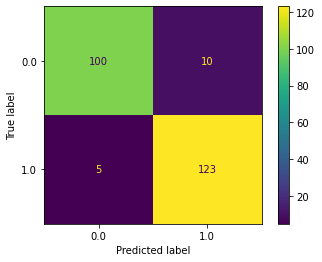


Random Forest Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       110
         1.0       0.92      0.96      0.94       128

    accuracy                           0.94       238
   macro avg       0.94      0.94      0.94       238
weighted avg       0.94      0.94      0.94       238


Accuracy: 0.937

 Random Forest Train/Test/CV Scoring
           train   test     cv
recall     0.961  0.935  0.922
precision  0.961  0.939  0.920
f1         0.961  0.936  0.920


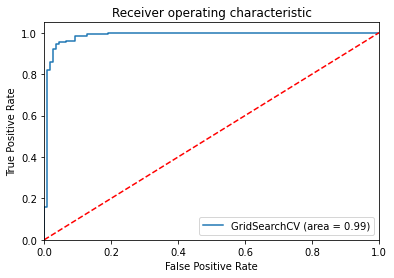

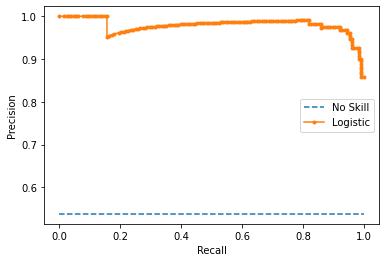

In [214]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(max_depth=160, min_samples_leaf=5,
                            min_samples_split=10, n_estimators=500, random_state=42)
rfc.fit(x_train, y_train)
rfc_predictions = rfc.predict(x_test)
rfc_predictions_train=rfc.predict(x_train)

rfc_matrix = metrics.confusion_matrix(y_test,rfc_predictions)

plot_confusion_matrix(rfc, x_test, y_test)  
plt.show()

class_report_rfc = classification_report(y_test, rfc_predictions)
print("\nRandom Forest Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,rfc_predictions),3))


print('\n Random Forest Train/Test/CV Scoring')
print(fitting_score(rfc_predictions_train, rfc_predictions, rfc))

roc_curve(rfc)

pr_graph(rfc)

### 9.2 Feature Analysis via GLM Logistic Regression 

In [148]:
logreg = LogisticRegression().fit(x_train,y_train)
logreg

print("Training set score: {:.3f}".format(logreg.score(x_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(x_test,y_test)))

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print("\n", result.summary())

Training set score: 0.822
Test set score: 0.874
         Current function value: 0.348987
         Iterations: 35

                            Logit Regression Results                           
Dep. Variable:          Patent_Status   No. Observations:                 1190
Model:                          Logit   Df Residuals:                     1152
Method:                           MLE   Df Model:                           37
Date:                Sun, 31 Jul 2022   Pseudo R-squ.:                  0.4943
Time:                        17:30:34   Log-Likelihood:                -415.29
converged:                      False   LL-Null:                       -821.29
Covariance Type:            nonrobust   LLR p-value:                1.489e-146
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Country_WIPO_ID   